# multiclass logistic regression


In [26]:
import pandas as pd
import numpy as np
import sys
import sklearn
import io
import random
import time


In [27]:
#read the data and rename 
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]
traindata = pd.read_csv('kdd_10_train.tab',delimiter=' ')
validdata = pd.read_csv('kdd_10_test.tab',delimiter=' ')
testdata = pd.read_csv('corrected', header=None, names = col_names)
traindata.drop('class', axis=1, inplace=True)
validdata.drop('class', axis=1, inplace=True)
traindata.rename(columns={'normal':'label'}, inplace=True)
validdata.rename(columns={'normal':'label'}, inplace=True)

print('Dimensions of the Traindata:',traindata.shape)
print('Dimensions of the Testdata:',testdata.shape)


Dimensions of the Traindata: (444618, 42)
Dimensions of the Testdata: (311029, 42)


In [28]:
#distribution of the label
print('Label distribution Training set:')
print(traindata['label'].value_counts())
print('Label distribution Test set:')
print(testdata['label'].value_counts())


Label distribution Training set:
smurf.              252628
neptune.             96625
normal.              87458
back.                 1992
satan.                1449
ipsweep.              1124
portsweep.             929
warezclient.           917
teardrop.              885
pod.                   246
nmap.                  202
guess_passwd.           49
buffer_overflow.        29
warezmaster.            19
land.                   19
imap.                   12
loadmodule.              8
ftp_write.               7
rootkit.                 7
multihop.                6
phf.                     3
perl.                    2
spy.                     2
Name: label, dtype: int64

Label distribution Test set:
smurf.              164091
normal.              60593
neptune.             58001
snmpgetattack.        7741
mailbomb.             5000
guess_passwd.         4367
snmpguess.            2406
satan.                1633
warezmaster.          1602
back.                 1098
mscan.              

## Data process

In [29]:
print('Training set:')
for feature in traindata.columns:
    if traindata[feature].dtypes == 'object' :
        unique_cat = len(traindata[feature].unique())
        print("Feature '{feature}' has {unique_cat} categories".format(feature=feature, unique_cat=unique_cat))

print()
print('Distribution of categories in service:')
print(traindata['service'].value_counts().sort_values(ascending=False).head())


Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 66 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
ecr_i      253190
private     99972
http        57796
smtp         8753
other        6513
Name: service, dtype: int64


## label encoder

I first use the label encoder to deal with the categorial features. Since some models such as KNN use distances of features as the decision creteria, one-hot-encoder would be more suitable to deal with the categorial features.

In [30]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_feature=['protocol_type', 'service', 'flag']

train_categorical_values = traindata[categorical_feature]
test_categorical_values = testdata[categorical_feature]

train_categorical_values.head()

,protocol_type,service,flag
0,tcp,http,SF
1,tcp,http,SF
2,tcp,http,SF
3,tcp,http,SF
4,tcp,http,SF


## rename the column

In [31]:
#all data for one hot encoder
df = pd.read_csv('kddcup.data_10_percent_corrected',delimiter=',',header=None)

col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

df.columns=col_names 

In [32]:
# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
print(unique_protocol2)

# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
print(unique_service2)


# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
print(unique_flag2)


# put together
dfcols=unique_protocol2 + unique_service2 + unique_flag2




['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp']
['service_IRC', 'service_X11', 'service_Z39_50', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_hostnames', 'service_http', 'service_http_443', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'service_rje', 'service_shell', 'service_smtp', 'service_sql_net', 'service_ssh'

In [33]:
train_categorical_values_enc=train_categorical_values.apply(LabelEncoder().fit_transform)

print(train_categorical_values.head())
print('--------------------')
print(train_categorical_values_enc.head())

# test set

test_categorical_values_enc=test_categorical_values.apply(LabelEncoder().fit_transform)


  protocol_type service flag
0           tcp    http   SF
1           tcp    http   SF
2           tcp    http   SF
3           tcp    http   SF
4           tcp    http   SF
--------------------
   protocol_type  service  flag
0              1       22     9
1              1       22     9
2              1       22     9
3              1       22     9
4              1       22     9


## one-hot-encoder

In [34]:
#delete the incorrect data
testdata=testdata[-testdata.service.isin(['icmp'])]
testdata.reset_index(drop=True, inplace=True)

In [35]:
enc = OneHotEncoder(categories='auto')

enc.fit(df[categorical_feature])

#train set
train_categorical_values_encenc = enc.transform(traindata[categorical_feature])
train_cat_data = pd.DataFrame(train_categorical_values_encenc.toarray(),columns=dfcols)

#valid set
valid_categorical_values_encenc = enc.transform(validdata[categorical_feature])
valid_cat_data = pd.DataFrame(valid_categorical_values_encenc.toarray(),columns=dfcols)


# test set
test_categorical_values_encenc = enc.transform(testdata[categorical_feature])
test_cat_data = pd.DataFrame(test_categorical_values_encenc.toarray(),columns=dfcols)

train_cat_data.head()


,Protocol_type_icmp,Protocol_type_tcp,Protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## combine all the column

In [36]:
#traindata
newtrain=traindata.join(train_cat_data)
newtrain.drop('flag', axis=1, inplace=True)
newtrain.drop('protocol_type', axis=1, inplace=True)
newtrain.drop('service', axis=1, inplace=True)


#valid data
newvalid=validdata.join(valid_cat_data)
newvalid.drop('flag', axis=1, inplace=True)
newvalid.drop('protocol_type', axis=1, inplace=True)
newvalid.drop('service', axis=1, inplace=True)


# test data
newtest=testdata.join(test_cat_data)
newtest.drop('flag', axis=1, inplace=True)
newtest.drop('protocol_type', axis=1, inplace=True)
newtest.drop('service', axis=1, inplace=True)


print(newtrain.shape)
print(newvalid.shape)
print(newtest.shape)


(444618, 119)
(49402, 119)
(311027, 119)


## classify the label

In [37]:
#normal: 0;
#Probe = ("ipsweep.", "portsweep.", "nmap.", "satan." , "saint.", "mscan."):1
#UR2 = ("buffer_overflow.","loadmodule.", "perl.", "rootkit.", "xterm.", "ps.", "httptunnel.", "sqlattack.", "worm.", "snmpguess.", "spy." ):2
#DDoS = ('neptune.', 'smurf.', 'pod.', 'teardrop.', 'land.', "back.", "apache2.", "udpstorm.", "processtable.", "mailbomb."):3
#R2L = ("guess_passwd.", "ftp_write.", "imap.", "phf.", "multihop.", "warezmaster.", "warezclient.", "snmpgetattack.", "named.", "xlock." , "xsnoop.", "sendmail." ):4


labeltrain=newtrain['label']
labelvalid=newvalid['label']
labeltest=newtest['label']
newlabeltrain=labeltrain.replace({ 'normal.' : 0, 'ipsweep.':1, 'portsweep.':1,'nmap.':1,'satan.':1,'buffer_overflow.':2,'loadmodule.':2,'perl.':2,'rootkit.':2,'back.':3,'land.':3,'neptune.':3, 'pod.':3,'smurf.':3,
                            'teardrop.':3, 'ftp_write.':4,'guess_passwd.':4,'imap.':4,'multihop.':4, 'phf.':4,'spy.':4,'warezclient.':4,'warezmaster.':4 })
newlabelvalid=labelvalid.replace({ 'normal.' : 0, 'ipsweep.':1, 'portsweep.':1,'nmap.':1,'satan.':1,'buffer_overflow.':2,'loadmodule.':2,'perl.':2,'rootkit.':2,'back.':3,'land.':3,'neptune.':3, 'pod.':3,'smurf.':3,
                            'teardrop.':3, 'ftp_write.':4,'guess_passwd.':4,'imap.':4,'multihop.':4, 'phf.':4,'spy.':4,'warezclient.':4,'warezmaster.':4 })
newlabeltest=labeltest.replace({ 'normal.' : 0, 'ipsweep.':1, 'portsweep.':1,'nmap.':1,'satan.':1,"saint.":1,"mscan.":1,'buffer_overflow.':2,'loadmodule.':2,'perl.':2,'rootkit.':2,"xterm.":2, "ps.":2, "httptunnel.":2, "sqlattack.":2, "worm.":2, "snmpguess.":2, "spy.":2, 
                            'back.':3,'land.':3,'neptune.':3, 'pod.':3,'smurf.':3,'teardrop.':3,"apache2.":3,  "udpstorm.":3, "processtable.":3, "mailbomb.":3,
                            'ftp_write.':4,'guess_passwd.':4,'imap.':4,'multihop.':4, 'phf.':4,'spy.':4,'warezclient.':4,'warezmaster.':4,'snmpgetattack.':4,'named.':4, "xlock.":4 , "xsnoop.":4, "sendmail.":4  })
# put the new label column back
# put the new label column back
newtrain['label'] = newlabeltrain
newvalid['label'] = newlabelvalid
newtest['label'] = newlabeltest


In [13]:
#write csv for convenience
newtrain.to_csv("kdd_train_class.csv")
newtest.to_csv("kdd_test_class.csv")

In [38]:
newtrain.head(5)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,239,486,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,219,1337,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,217,2032,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,217,2032,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,212,1940,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [39]:
#train set
X_train = newtrain.drop('label',1)
Y_train = newtrain.label

#valid set
X_valid = newvalid.drop('label',1)
Y_valid = newvalid.label

# test set
X_test = newtest.drop('label',1)
Y_test = newtest.label

C:\Users\haile\AppData\Local\Temp\ipykernel_20796\2004389754.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = newtrain.drop('label',1)
C:\Users\haile\AppData\Local\Temp\ipykernel_20796\2004389754.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_valid = newvalid.drop('label',1)
C:\Users\haile\AppData\Local\Temp\ipykernel_20796\2004389754.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_test = newtest.drop('label',1)


In [40]:
#normalize the catgorial features
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
X_train = mm.fit_transform(X_train)
X_valid = mm.fit_transform(X_valid)
X_test = mm.fit_transform(X_test)

In [41]:
print(X_train.shape)
print(Y_train.shape)


(444618, 118)
(444618,)


## logistic regression

In [58]:
#%%
import sklearn

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class='multinomial',solver='sag',class_weight='balanced',max_iter=300)
#For multiclass problems, only 'newton-cg', 'sag', 'saga' and 'lbfgs' handle multinomial loss

train0=time.time()
lr.fit(X_train,Y_train) ##fit the model
train1 = time.time() - train0
print("train_time:%.3fs\n" %train1)

score = lr.score(X_train,Y_train)
print(score)

train_time:266.089s

0.9812535704807273


c:\Users\haile\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [59]:
#%%

valid_score =lr.score(X_valid,Y_valid)
print(valid_score)
test_score = lr.score(X_test,Y_test)
print(test_score)

0.9815999352252945
0.8134856459407062


In [60]:
#%%
#prob for each class
y_pro = lr.predict_proba(X_test) 
print(y_pro)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [61]:
#performance for validation set
valid0=time.time()
y_predict0 = lr.predict(X_valid)
valid1=time.time()-valid0
print("test_time:%.3fs\n" %valid1)

from sklearn.metrics import classification_report
print('test index:\n',classification_report(Y_valid,y_predict0,digits=4))

test_time:0.008s

test index:
               precision    recall  f1-score   support

           0     0.9633    0.9513    0.9573      9819
           1     0.7510    0.9504    0.8390       403
           2     0.0769    0.3333    0.1250         6
           3     1.0000    0.9897    0.9948     39063
           4     0.2102    0.9640    0.3452       111

    accuracy                         0.9816     49402
   macro avg     0.6003    0.8377    0.6522     49402
weighted avg     0.9888    0.9816    0.9845     49402



In [62]:
#confusion matrix for validation data
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Y_valid, y_predict0)
cm_pd_0 = pd.DataFrame(data = cm,columns=['normal','probe','ur2','ddos','r2l'], index=['normal','probe','ur2','ddos','r2l'])
print(cm_pd_0)

        normal  probe  ur2   ddos  r2l
normal    9341     60   21      0  397
probe       19    383    1      0    0
ur2          2      0    2      0    2
ddos       333     67    0  38660    3
r2l          2      0    2      0  107


In [63]:
#normal: 0;
#Probe = ("ipsweep.", "portsweep.", "nmap.", "satan." , "saint.", "mscan."):1
#UR2 = ("buffer_overflow.","loadmodule.", "perl.", "rootkit.", "xterm.", "ps.", "httptunnel.", "sqlattack.", "worm.", "snmpguess.", "spy." ):2
#DDoS = ('neptune.', 'smurf.', 'pod.', 'teardrop.', 'land.', "back.", "apache2.", "udpstorm.", "processtable.", "mailbomb."):3
#R2L = ("guess_passwd.", "ftp_write.", "imap.", "phf.", "multihop.", "warezmaster.", "warezclient.", "snmpgetattack.", "named.", "xlock." , "xsnoop.", "sendmail." ):4

#performance for test data
test0=time.time()
y_predict = lr.predict(X_test)
test1=time.time()-test0
print("test_time:%.3fs\n" %test1)


print(y_predict)
from sklearn.metrics import classification_report
print('test index:\n',classification_report(Y_test,y_predict,digits=4))

test_time:0.045s

[0 0 0 ... 0 0 0]
test index:
               precision    recall  f1-score   support

           0     0.5143    0.9674    0.6716     60591
           1     0.7780    0.8337    0.8049      4166
           2     0.2784    0.0186    0.0349      2636
           3     0.9967    0.8231    0.9017    229853
           4     0.6472    0.1217    0.2049     13781

    accuracy                         0.8135    311027
   macro avg     0.6429    0.5529    0.5236    311027
weighted avg     0.8782    0.8135    0.8173    311027



In [64]:
#confusion matrix for test data
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Y_test, y_predict)
cm_pd = pd.DataFrame(data = cm,columns=['normal','probe','ur2','ddos','r2l'], index=['normal','probe','ur2','ddos','r2l'])
print(cm_pd)

        normal  probe  ur2    ddos   r2l
normal   58615    475   92     598   811
probe      592   3473    8      23    70
ur2       2564      5   49       0    18
ddos     40121    510    5  189202    15
r2l      12080      1   22       1  1677


Text(0.5, 0, 'Forecast type')

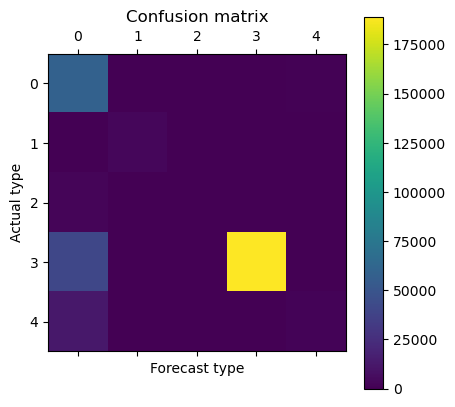

In [65]:
import matplotlib.pyplot as plt
plt.matshow(confusion_matrix(Y_test, y_predict))
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Actual type') 
plt.xlabel('Forecast type') 